In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

/export/bbq2/dfm/anaconda3/lib/python3.4/site-packages/astropy/config/configuration.py:682: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Could not find unix home directory to search for astropy config dir on None
  warn(ConfigurationMissingWarning(msg))


In [30]:
campaign = 1
epicid = "201178308"
# epicid = "201367065"
# epicid = "201912552"
# epicid = "201754305"

# campaign = 3
# epicid = "206475757"

# campaign = 4
# epicid = "211056809"
# epicid = "211028585"

basepath = "/export/bbq2/dfm/k2/web"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    alpha=500*np.log(100),
    min_transits=3,
    detrend=True,
    invert=False,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2015.0,
    # initial_time=2179.0,
    # initial_time=2264.0,
    skip=50,
    durations=[0.05],
    min_period=1.0,
    max_period=40.,
    npeaks=3,
    mask_frac=1.0,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [31]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True, clobber=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [32]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 1.05s
Querying Likelihood
tau = 9.42840576171875
tau = 9.42840576171875
tau = 9.42840576171875
tau = 9.42840576171875
tau = 2.087158203125
tau = 2.06182861328125
tau = 2.06182861328125
tau = 2.06182861328125
Finished querying Likelihood in 12.12s
Querying OneDSearch
Finished querying OneDSearch in 12.93s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 62.00s
Querying Vetter
Finished querying Vetter in 49.23s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


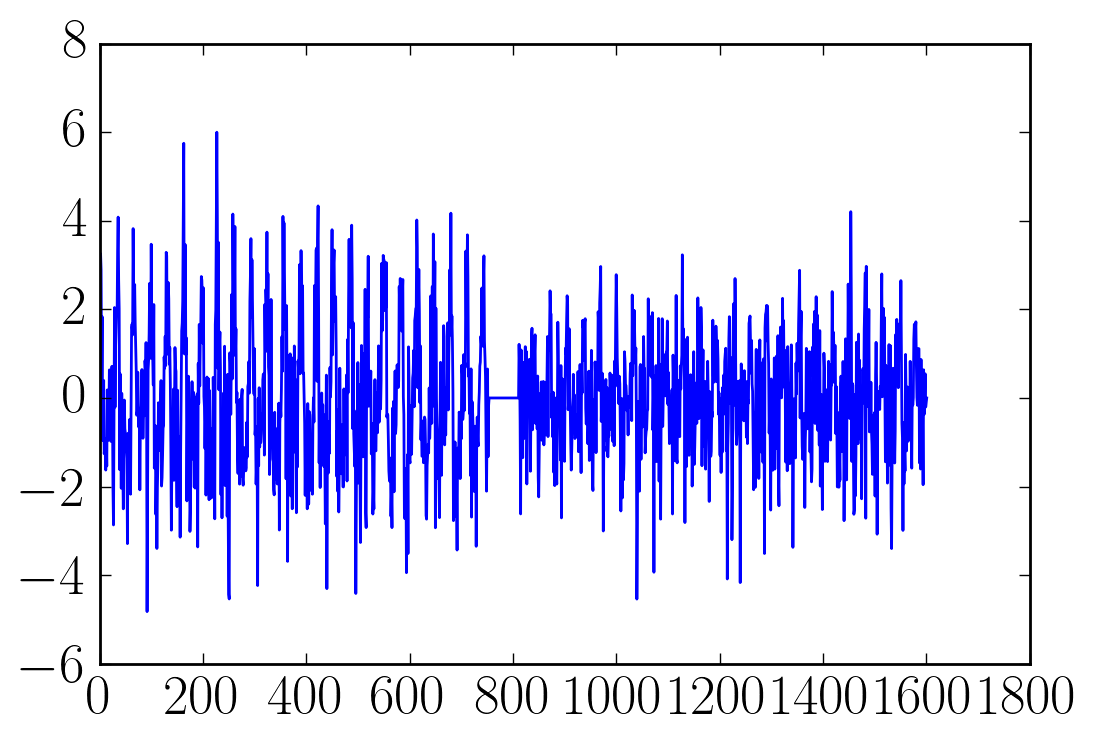

In [33]:
pl.plot(r.depth_1d * np.sqrt(r.depth_ivar_1d))

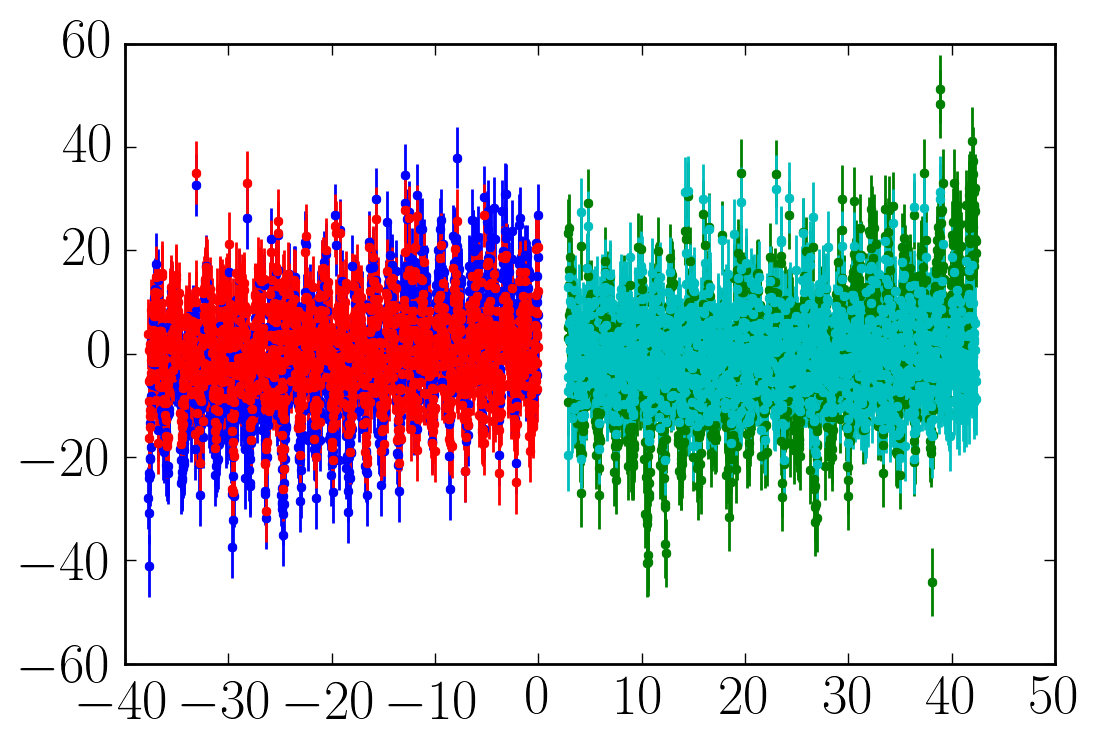

In [34]:
lcs = r.model_light_curves
[pl.errorbar(lc.time, lc.flux, yerr=lc.ferr, fmt=".", capsize=0) for lc in lcs];
[pl.errorbar(lc.time, lc.detrend_flux, yerr=lc.detrend_ferr, fmt=".", capsize=0) for lc in lcs];

In [35]:
r.peaks

[{'data_span': 80.072509765625,
  'depth': 8.8475559460076489,
  'depth_ivar': 2.9543488759929635,
  'duration': 0.05,
  'duty_cycle': 0.96129837702871412,
  'lnZ_box': -3165.0646626461753,
  'lnZ_none': -3455.5463708176167,
  'lnZ_outlier': -3431.1938895231074,
  'lnZ_period': -2395.3568379977528,
  'lnZ_transit': -2218.531552624183,
  'lnZ_vee': -2250.9925429879822,
  'lnlike_box': -3150.5872187867949,
  'lnlike_none': -3455.5463708176167,
  'lnlike_outlier': -3436.7455202590472,
  'lnlike_period': -2393.0128611598507,
  'lnlike_transit': -2202.9492699999532,
  'lnlike_vee': -2236.8048843942029,
  'osc_period': 1.6078817222012987,
  'period': 1.6111411430756646,
  'phic_same': 1223.1225155615198,
  'phic_same_second': 1211.8097170029396,
  'phic_variable': -52740.08404737727,
  's2n': 15.207373312868423,
  't0': 1.0050827463159528,
  'transit_b': 1.0605212399606336,
  'transit_duration': 1.1004599562164883,
  'transit_period': 1.6093655215182598,
  'transit_q1': 0.99963442926783352,


(-0.0020133928747486651, 1.9979866071252514)

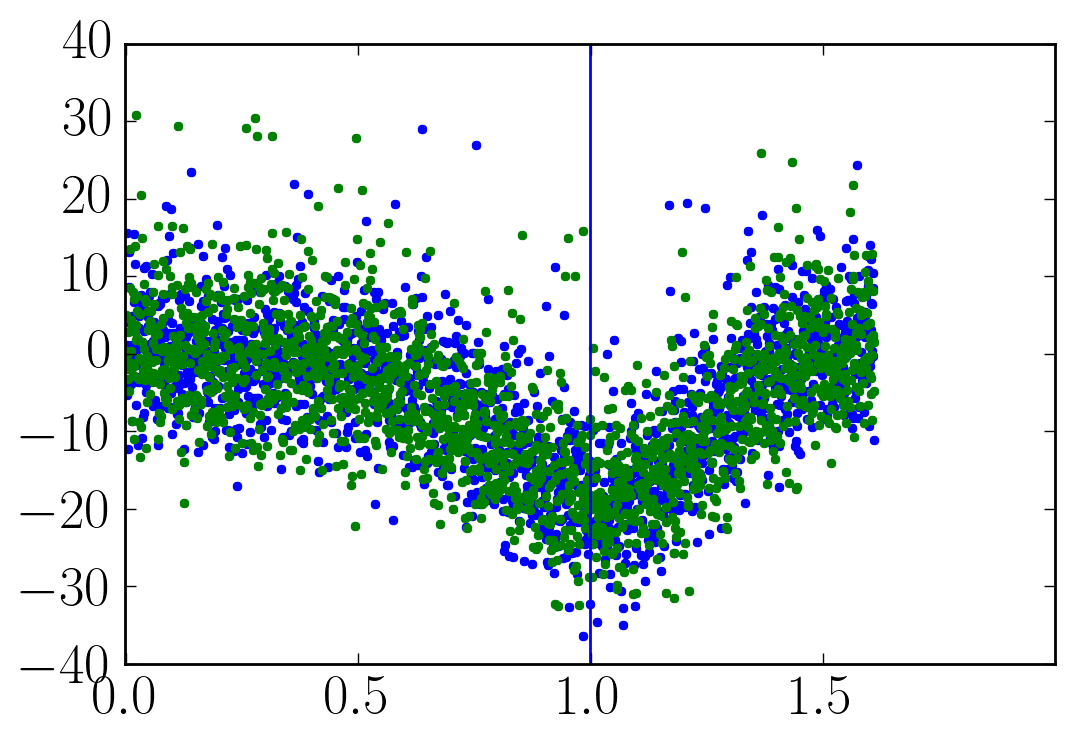

In [36]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

mod = [1e3*(s.light_curve(lc.time)-1.0) for lc in lcs]
[pl.plot(lc.time %  p["transit_period"], lc.flux - lc.predict(lc.flux - m), ".") for lc, m in zip(lcs, mod)]
# [pl.plot(lc.time %  p["transit_period"], m, ".") for lc, m in zip(lcs, mod)]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-1, p["transit_t0"]+1)